# Customer Segmentation using Kmeans Clustering

This notebook serves as an introduction to the k-means clustering method for customer segementation. 

K-means clustering is the most commonly used unsupervised machine learning algorithm for partitioning a given data set into a set of k groups (i.e. k clusters), where k represents the number of groups pre-specified by the analyst. 

**Dataset**

We will use this Kaggle dataset https://www.kaggle.com/imakash3011/customer-personality-analysis

## Import
Import relevant Python libraries needed. Major libriaries we use:
- pandas - allow us structure data within a dataframe
- matplotlib and seaborn - data visualisation
- sklearn - for classification

In [1]:
import pandas as pd
import csv
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
# PCA and Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
#K-means Clustering
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer



# Styling
Reference
- Seaborn color: https://seaborn.pydata.org/tutorial/color_palettes.html
- Matplotlib color: https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [2]:
palette1 = "muted" # default color palette before profiling
palette2 = "coolwarm" # default color palette for profiling
cmap = "Paired" # color palettes for correlation matrix

# set color palette
sns.set_palette(palette1)

## Reading data

This dataset is in tab-delimited csv format. Let’s begin by reading the data as a pandas DataFrame: 

In [3]:
df = pd.read_csv('marketing_campaign.csv',sep='\t')

To test that data was properly read, we can print the first 5 records and count total number of rows and column.

In [4]:
column_names = list(df.columns)
print('Total row: ', len(df))
print('Total column: ', len(df.columns))
df.head()

Total row:  2240
Total column:  29


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Cleaning and EDA

In this section, we handle data exploration on the dataset, such as checking data meta and missing data. It is an unskippable step as data is usually messsy. We have to ensure data is cleaned and transformed in a form that can be analyzed.

Critical tasks to be performed:
- Check metadata
- Missing value in the dataset -> removed or estimated
- Preprocess exisiting features and create new features
- Handle outliers


First, take a look on the summary of the dataframe. [Attribute information](https://www.kaggle.com/imakash3011/customer-personality-analysis)

In [5]:
data_info = pd.DataFrame(columns=['Column', 'Null Count', 'Dtype', 'Unique'])

for i in range(0, len(df.columns)):
    data_info.loc[i] = [df.columns[i],
                        df[df.columns[i]].isnull().sum(),
                        df[df.columns[i]].dtypes,
                        df[df.columns[i]].nunique()] 
print(data_info)

                 Column Null Count    Dtype Unique
0                    ID          0    int64   2240
1            Year_Birth          0    int64     59
2             Education          0   object      5
3        Marital_Status          0   object      8
4                Income         24  float64   1974
5               Kidhome          0    int64      3
6              Teenhome          0    int64      3
7           Dt_Customer          0   object    663
8               Recency          0    int64    100
9              MntWines          0    int64    776
10            MntFruits          0    int64    158
11      MntMeatProducts          0    int64    558
12      MntFishProducts          0    int64    182
13     MntSweetProducts          0    int64    177
14         MntGoldProds          0    int64    213
15    NumDealsPurchases          0    int64     15
16      NumWebPurchases          0    int64     15
17  NumCatalogPurchases          0    int64     14
18    NumStorePurchases        

In [6]:
# Enrollment date
df.Dt_Customer.value_counts()

31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
25-05-2013     1
14-04-2013     1
09-01-2014     1
Name: Dt_Customer, Length: 663, dtype: int64

Total 28 attributes, 25 numberic and 3 categorical.

Numeric attributes
- Z_CostContact and Z_Revenue only have 1 unique values and unclear about the defintion. Should be dropped

Categorical attributes: Education, Marital_Status and Dt_customers
- Dt_customer has 663 unique values and is a date field. Will convert to DD-YYYY format
- Education and Marital Status, to-do visualisation in later section to analyze if useful for classification 

**Missing value in the dataset**

24 records found with missing Income. For simplicity, we drop the NA data found as they only took 1% of total.

<AxesSubplot:>

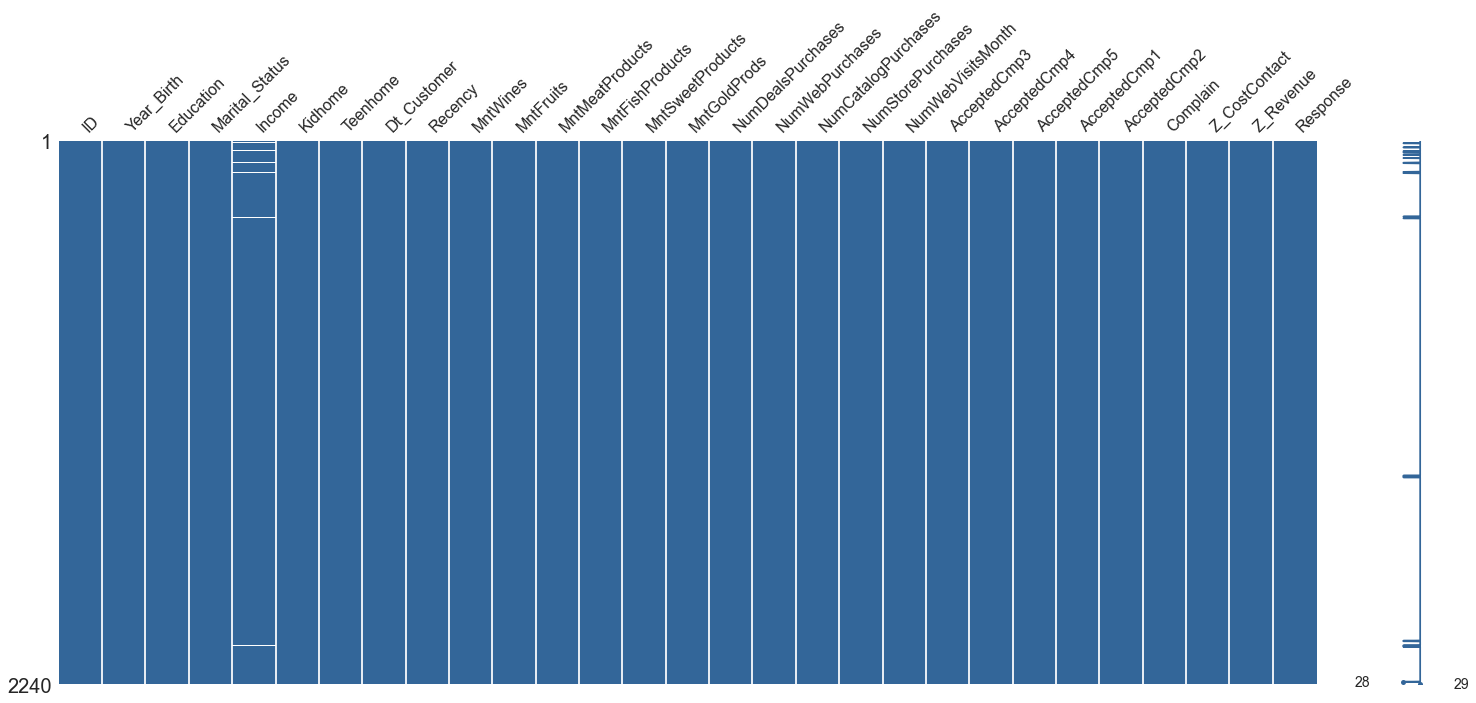

In [7]:
# Visualisation of Missing cell 
msno.matrix(df, color=(0.2, 0.4, 0.6))

In [8]:
# Drop NA data
df = df.dropna(subset=['Income'])

**Cleaning exisiting features and create new features**

Ideas of this part:

- Age: Convert Year_birth to Age 
- Dt_customer: Convert to MM-YYYY format
- Spending: Sum all the monetary amount spend on Wines, Fruits, Meat Products, Fish Products, Sweet Product and Gold Products.
- Frequency: Sum all the number of purchase on different channels - Online, Catelog, Store
- Number of child: Sum the number of Kid and Teen at home
- Household size
- Drop irrelevant feature for further analysis


In [9]:
# Current feature: Convert Year_Birth to Age
def calculateAge(birthYear):
    today = date.today()
    age = today.year - birthYear
    return age

# Calcuate age and add new column
df['Age']  = calculateAge(df['Year_Birth'].values)

In [10]:
# Current feature: Convert enrollment date Dt_Customer to MM-YYYY
def convertEnrollDate(date):
    for i in date:
        print(date[i].split("-",1))
    return date.split("-",1)

df['Dt_Customer']  = df['Dt_Customer'].str.split('-',1).str[-1]
df['Dt_Customer'].head()

0    09-2012
1    03-2014
2    08-2013
3    02-2014
4    01-2014
Name: Dt_Customer, dtype: object

In [11]:
# New features
df['Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'] 
df['Frequency'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] 
df['NumChild'] = df['Kidhome'] + df['Teenhome']
df['Household_size'] = df['NumChild'] + df['Marital_Status'].replace({'Married': 2, 'Together': 2, 'Absurd': 1, 'Widow': 1, 'YOLO': 1, 'Divorced': 1, 'Single': 1, 'Alone': 1})

The value of Z_CostContact and Z_Revenue are the same among all records, so it is irrelevant for analysis.
Customer ID is unique to each customer, so not meaningful for analysis.

In [12]:
# Drop irrelevant or rededant feature
df = df.drop(['ID','Z_CostContact','Z_Revenue','Year_Birth'], axis=1)

**Handle Outliers**

There are several ways to handle outliers and let's take a look on the data to determine which method suit the best.
- Quantile-based Flooring and Capping
- Trimming / Dropping the outliers
- IQR Score
- Log Transformation

In [13]:
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Frequency,NumChild,Household_size
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.073105,0.064079,0.013538,0.009477,0.150271,53.179603,607.075361,14.880866,0.947202,2.592509
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.260367,0.244950,0.115588,0.096907,0.357417,11.985554,602.900476,7.670957,0.749062,0.905722
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,5.000000,0.000000,0.000000,1.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,69.000000,8.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,396.500000,15.000000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1048.000000,21.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,129.000000,2525.000000,44.000000,3.000000,5.000000


From above table, we can see that mean and max of Income and Age look strange. Let us further plot pairwise relationships of selected features to identify any outliers.

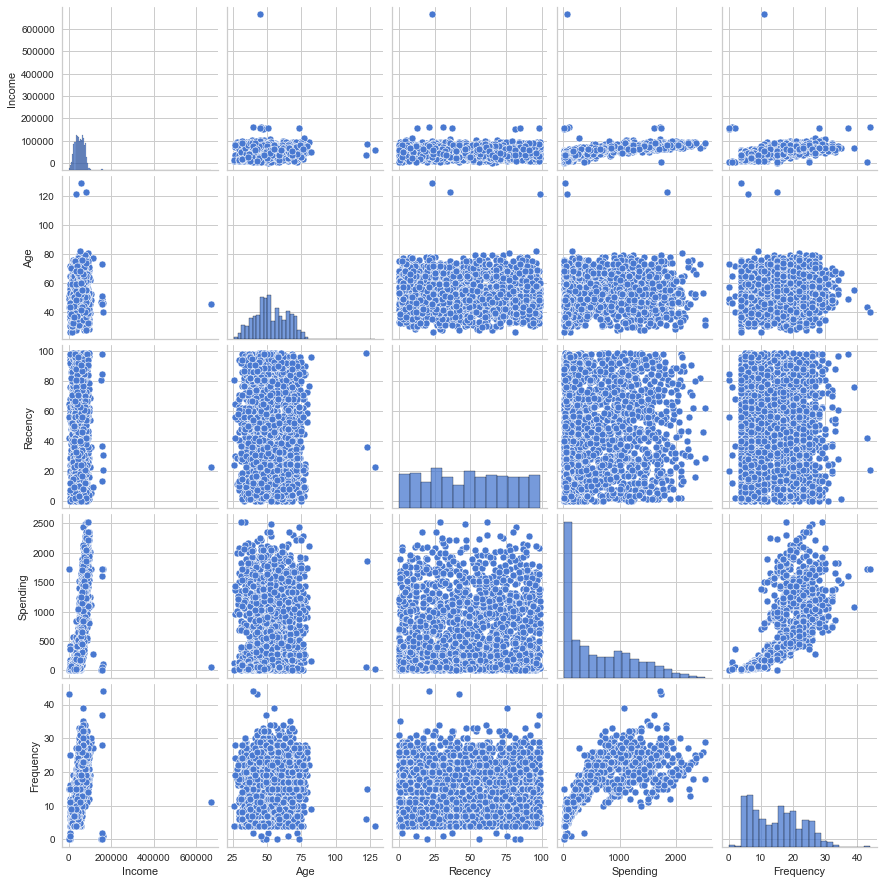

In [14]:
check_col = ['Income' , 'Age', 'Recency', 'Spending' , 'Frequency' ]
sns.pairplot(df[check_col])

From above, we can observe that Income and Age are likely having outliers.

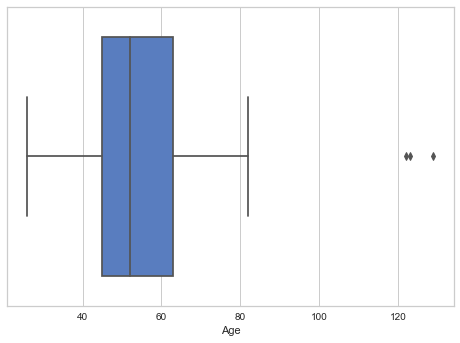

In [15]:
# Outlier visualisation for AGE
sns.boxplot(data = df, x = 'Age')
plt.show()

In [16]:
# Print the details of outliers
df[df.Age >= 100]

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Frequency,NumChild,Household_size
192,2n Cycle,Divorced,36640.0,1,0,09-2013,99,15,6,8,...,0,0,0,1,0,122,65,6,1,2
239,2n Cycle,Single,60182.0,0,1,05-2014,23,8,0,5,...,0,0,0,0,0,129,22,4,1,2
339,PhD,Together,83532.0,0,0,09-2013,36,755,144,562,...,1,0,0,0,0,123,1853,15,0,2


It is nonsense that 3 customers aged over 120 sare earning 36-84k. Look like some user input error that can simply drop them.

In [17]:
# Drop the outliers
df.drop(index = [192, 239, 339], axis = 0, inplace = True)

Let's recheck the outlier visualisation.

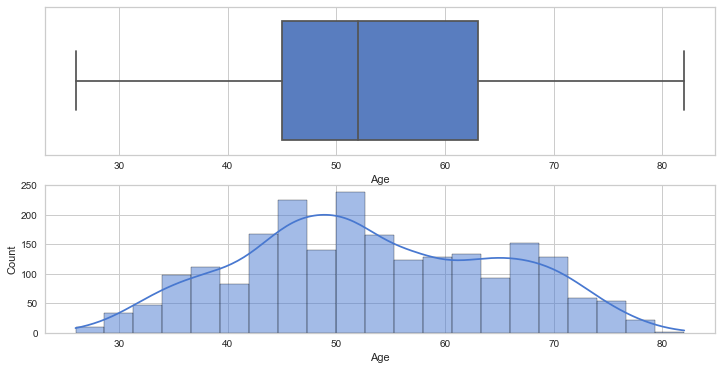

In [18]:
# Recheck outlier visualisation
fig, axes = plt.subplots(2, 1, figsize=(12,6))

sns.boxplot(data = df, x = 'Age', ax = axes[0])
sns.histplot(data = df, x = 'Age', kde=True, ax = axes[1])

plt.show()

For Income, we use Quantile-based Flooring and Capping to handle outliers. The outlier is capped at 90th percentile or floored below the 10th percentile.

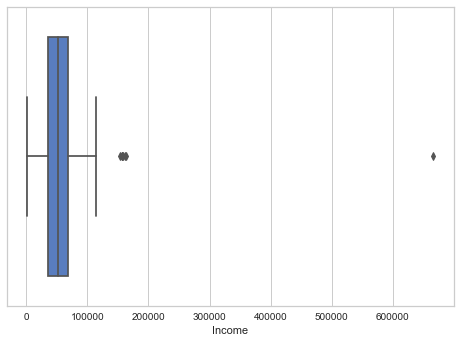

10th percentile: 24090.2 , 90th percentile: 79819.0


In [19]:
# Outlier visualisation for Income
sns.boxplot(data = df, x = 'Income')
plt.show()

# Get 10th and 90th percentile
income10 = df['Income'].quantile(0.10)
income90 = df['Income'].quantile(0.90)
print("10th percentile:", income10, ", 90th percentile:", income90)

In [20]:
# Apply Quantile-based flooring and capping
df["Income"] = np.where(df["Income"] < income10, income10,df['Income'])
df["Income"] = np.where(df["Income"] > income90, income90,df['Income'])
print("Quantile-based flooring and capping completed")

Quantile-based flooring and capping completed


Let's recheck the outlier visualisation.

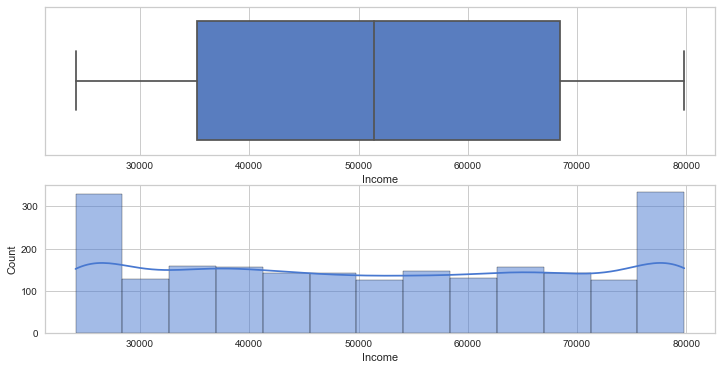

In [21]:
# Recheck outlier visualisation
fig, axes = plt.subplots(2, 1, figsize=(12,6))

sns.boxplot(data = df, x = 'Income', ax = axes[0])
sns.histplot(data = df, x = 'Income', kde=True, ax = axes[1])

plt.show()

**Correlation Analysis**

Correlation matrix is a table showing the value of the correlation coefficient (Correlation coefficients are used in statistics to measure how strong a relationship is between two variables) between sets of variables. Each attribute of the dataset is compared with the other attributes to find out the correlation coefficient. 

This analysis allows us to see which pairs have the highest correlation, the pairs which are highly correlated represent the same variance of the dataset thus we can further analyze them to understand which attribute among the pairs are most significant for building the model.

<AxesSubplot:>

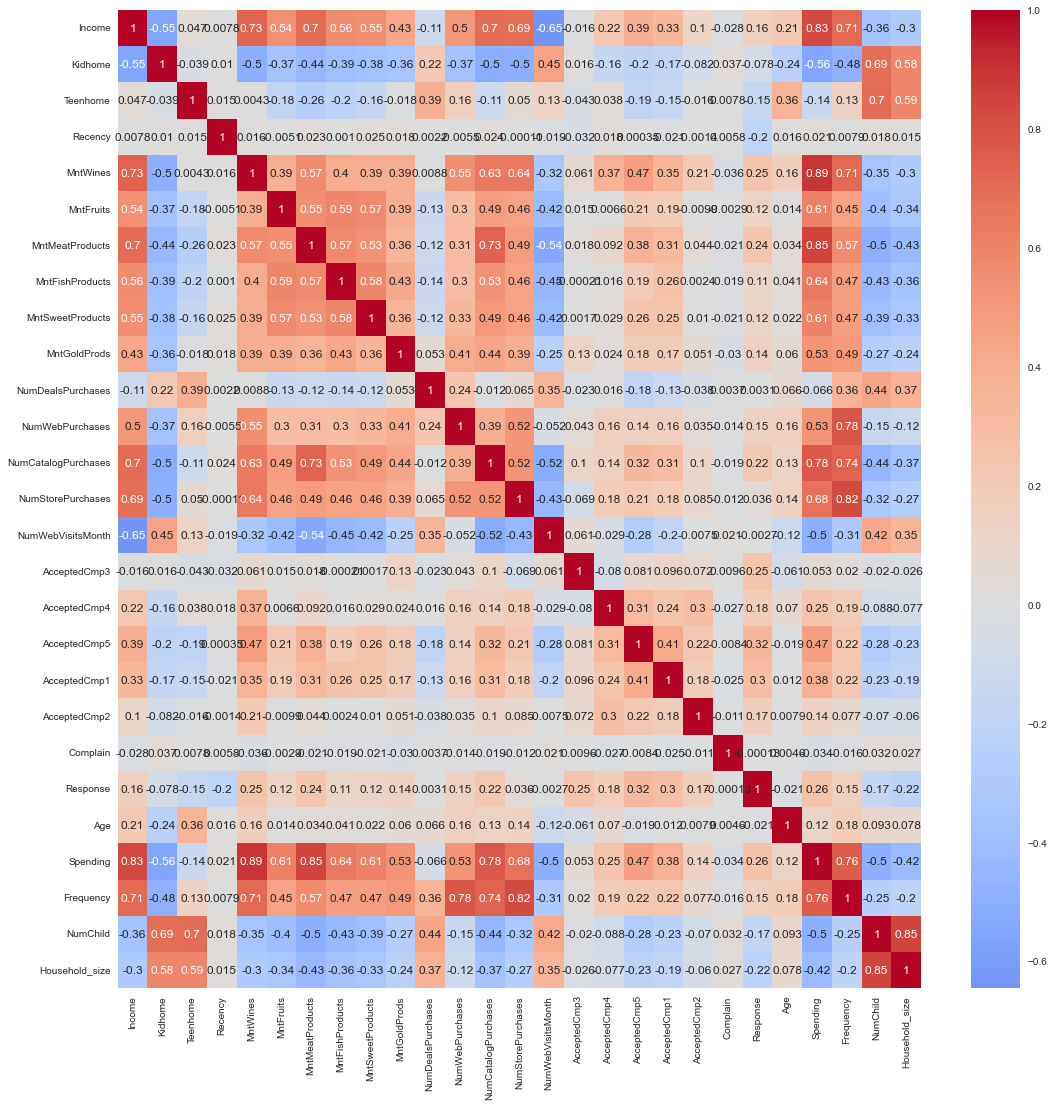

In [22]:
# correlation matrix

corrmat= df.corr()
plt.figure(figsize=(18,18))  
sns.heatmap(corrmat,annot=True, cmap="coolwarm", center=0)

As you can see in the above matrix, there is a high correlation between Spending and Income and also between Frequency and Income.

**Data Visualisation**

Below we create visulisation for categorical features and some numeric features.

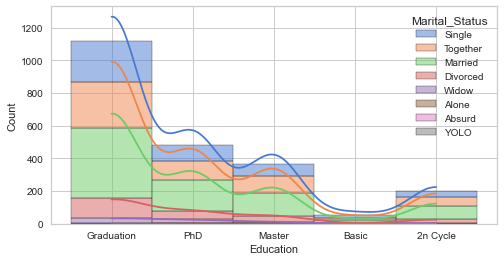

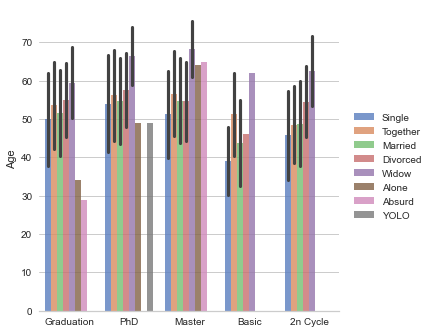

In [23]:
# Visualisation of categorical features - Education
fig = plt.figure(figsize=(8,4))
sns.histplot(data=df, x="Education", hue="Marital_Status", multiple="stack", kde=True, palette=palette1)
plt.show()

g =sns.catplot(
    data=df, kind="bar",
    x="Education", y="Age", hue="Marital_Status",
    ci="sd", alpha=.8, height=5)
g.despine(left=True)
g.set_axis_labels("", "Age")
g.legend.set_title("")

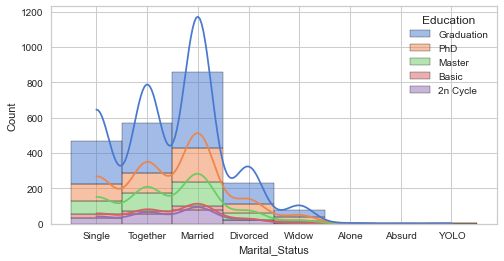

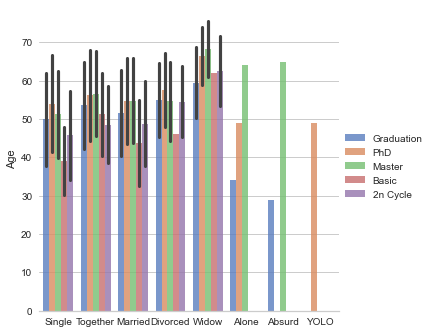

In [24]:
# Visualisation of categorical features
fig = plt.figure(figsize=(8,4))
sns.histplot(data=df, x="Marital_Status", hue="Education", multiple="stack", kde=True, palette=palette1)
plt.show()

g = sns.catplot(
    data=df, kind="bar",
    x="Marital_Status", y="Age", hue="Education",
    ci="sd", alpha=.8, height=5)
g.despine(left=True)
g.set_axis_labels("", "Age")
g.legend.set_title("")


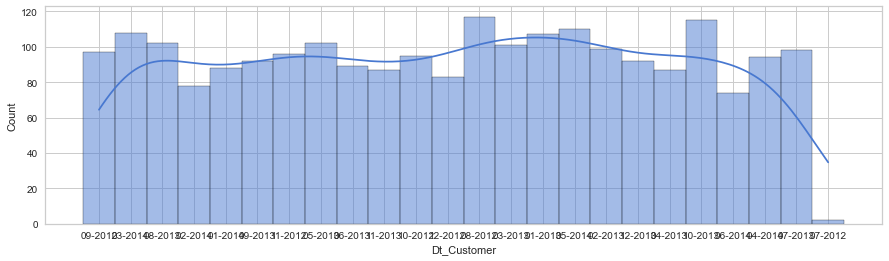

In [25]:
# Visualisation of categorical features - Dt_Customer
fig = plt.figure(figsize=(15,4))
sns.histplot(data=df, x="Dt_Customer",kde=True, palette=palette1)
plt.show()

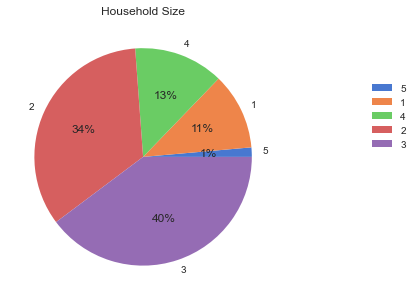

In [26]:
# Visualisation of new feature - Household size
x = df['Household_size'].value_counts().sort_values()
labels = df['Household_size'].value_counts().sort_values().index

plt.figure(figsize=(5, 5))
plt.pie(x = x, labels = labels, autopct='%.0f%%')
plt.title('Household Size')
plt.legend(bbox_to_anchor=(1.5,0.8))
plt.show()

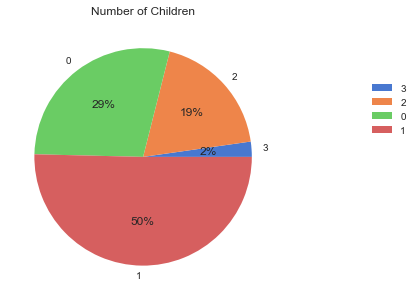

In [27]:
# Visualisation of new feature - NumChild
x = df['NumChild'].value_counts().sort_values()
labels = df['NumChild'].value_counts().sort_values().index

plt.figure(figsize=(5, 5))
plt.pie(x = x, labels = labels, autopct='%.0f%%')
plt.title('Number of Children')
plt.legend(bbox_to_anchor=(1.5,0.8))
plt.show()

# Data Preprocessing

- Label encoding for categorical variables
- Standard scaling for numerical variables

**Label Encoding for categorical variables**

Machine learning models require all input and output variables to be numeric.

In [28]:
LE=LabelEncoder()
object_cols = ['Education','Marital_Status','Dt_Customer']

for i in object_cols:
    df[i] = df[[i]].apply(LE.fit_transform)
    print(i, "after encoding:",dict(zip(LE.classes_, LE.transform(LE.classes_))))


Education after encoding: {'2n Cycle': 0, 'Basic': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
Marital_Status after encoding: {'Absurd': 0, 'Alone': 1, 'Divorced': 2, 'Married': 3, 'Single': 4, 'Together': 5, 'Widow': 6, 'YOLO': 7}
Dt_Customer after encoding: {'01-2013': 0, '01-2014': 1, '02-2013': 2, '02-2014': 3, '03-2013': 4, '03-2014': 5, '04-2013': 6, '04-2014': 7, '05-2013': 8, '05-2014': 9, '06-2013': 10, '06-2014': 11, '07-2012': 12, '07-2013': 13, '08-2012': 14, '08-2013': 15, '09-2012': 16, '09-2013': 17, '10-2012': 18, '10-2013': 19, '11-2012': 20, '11-2013': 21, '12-2012': 22, '12-2013': 23}


**Standard scaling for numerical variables**

Scaling helps to compare independent features with different ranges or units after converting them to comparable values. K-means is a distance based model that we need to standardise numeric variables to same scale so it wont impact the performance when making prediction.

[Reference: Two major scaling methods](https://towardsdatascience.com/one-hot-encoding-standardization-pca-data-preparation-steps-for-segmentation-in-python-24d07671cf0b)

In [29]:
# Create a subset of dataframe and drop the selected features
df2 = df.copy()

#drop_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Response', 'Complain']
drop_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Response', 'Complain']
df2 = df2.drop(drop_cols, axis=1)

# Standardization
scaler = StandardScaler()
scaler.fit(df2)
scaled_features = pd.DataFrame(scaler.transform(df2),columns= df2.columns)
df2.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spending,Frequency,NumChild,Household_size
0,2,4,58138.0,0,0,16,58,635,88,546,...,3,8,10,4,7,65,1617,25,0,1
1,2,4,46344.0,1,1,5,38,11,1,6,...,2,1,1,2,5,68,27,6,2,3
2,2,5,71613.0,0,0,15,26,426,49,127,...,1,8,2,10,4,57,776,21,0,2
3,2,5,26646.0,1,0,3,26,11,4,20,...,2,2,0,4,6,38,53,8,1,3
4,4,3,58293.0,1,0,1,94,173,43,118,...,5,5,3,6,5,41,422,19,1,3


# Feature Extraction
In this dataset, there are too many input variables that might impact the performance when making prediction. Therefore we will use PCA for dimensionality reduction in below cell. 

- Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables
- PCA is a technique that comes from the field of linear algebra and create a projection of a dataset prior to fitting a model.

### Dimensionality Reduction - Principal Component Analysis (PCA)
There are several way to decide the number of components to retain and we will use "Percent of variation threshold" this time.

In [30]:
# Loop Function to identify number of principal components that explain at least 85% of the variance
for comp in range(3, df2.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(df2)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.85:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
Final_PCA.fit(df2)
cluster_df=Final_PCA.transform(df2)
num_comps = comp_check.shape[0]
print("The optimal number of PCA is {} components, which get {}% of of variance explained.".format(final_comp,comp_check.sum()*100))

The optimal number of PCA is 3 components, which get 99.99730322251337% of of variance explained.


In [31]:
pca = PCA(n_components=final_comp)
pca_col = []
for i in range(final_comp):
    name = 'PC'+ str(i+1)
    pca_col.append(name)

pca.fit(scaled_features)
PCA_df = pd.DataFrame(pca.transform(scaled_features), columns=([pca_col]))
PCA_df.describe()

,PC1,PC2,PC3
count,2.213000e+03,2.213000e+03,2.213000e+03
mean,-6.802813e-17,3.802752e-17,3.441541e-17
std,2.913201e+00,1.700504e+00,1.190410e+00
min,-5.193655e+00,-3.738795e+00,-3.723189e+00
25%,-2.694624e+00,-1.376226e+00,-8.284482e-01
50%,-6.241666e-01,-1.938471e-01,-7.927946e-03
75%,2.602720e+00,1.218855e+00,7.916617e-01
max,7.367928e+00,6.540006e+00,5.326345e+00


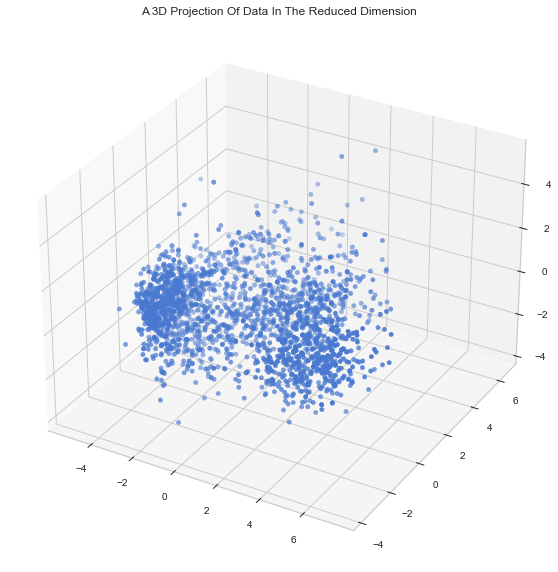

In [32]:
# 3D Projection
x =PCA_df["PC1"]
y =PCA_df["PC2"]
z =PCA_df["PC3"]
#To plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
#ax.scatter(x,y,z, c="magenta", marker="o" )
ax.scatter(x,y,z, marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering process 

Here we implement the following 3 steps to perform clustering process.

Step 1: Determine the best optimal number of clusters
- Elbow method: Calculating the Sum Sqaured Error according to the number of K
- Silhouette methodLink: Calculating the Silhouette score according to the number of K *(Not this time)*

Step 2: Apply Clustering 

- K-Means: Useful for the customer related data because it divides the data into the K sets simultaneously

Step 3: Evaluation the clusters

Visualize the result of clustering and evaluate how it is clustered well.

### Determine optimal number of clusters - Elbow method

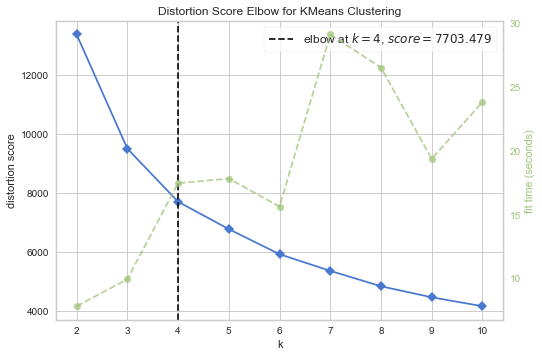

In [33]:
km = KMeans()
Elbow_M = KElbowVisualizer(km, k = 10)
Elbow_M.fit(PCA_df)
Elbow_M.show()

plt.show()

The best K for clustering by Elbow method is 4.

### Apply optimum k-means clustering

In [34]:
km = KMeans(n_clusters=4, random_state=42)

# Fit model and predict clusters
km_df = km.fit_predict(PCA_df)
PCA_df["Cluster"] = km_df

# Add the clusters to the orignal dataframe
df2["Cluster"]= km_df

### Evaluating Model

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

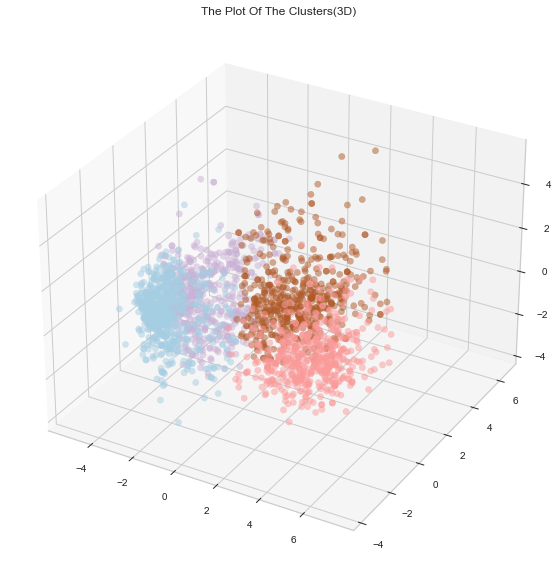

In [35]:
# 3 dimension plot of the clusters

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=PCA_df["Cluster"], marker='o', alpha = 0.5, cmap = cmap)
ax.set_title("The Plot Of The Clusters(3D)")

plt.show()

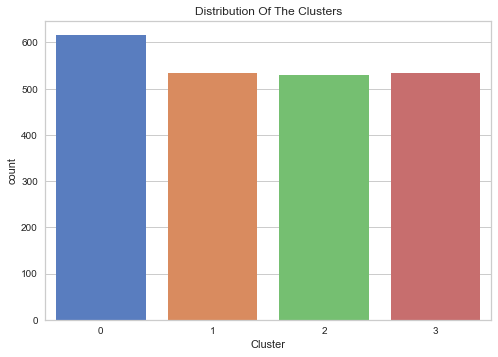

In [36]:
#Plotting countplot of clusters
pl = sns.countplot(x=df2["Cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()

The cluster is fairly distributed.

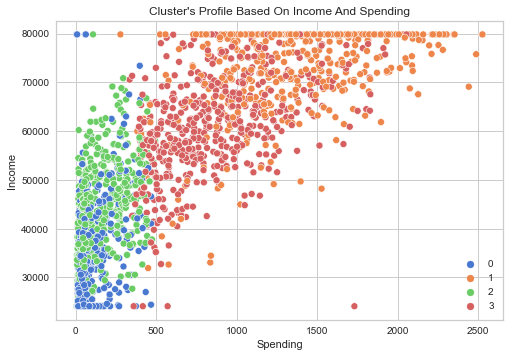

In [37]:
# Plot the relation of Spending and Income.
pl = sns.scatterplot(data = df2,x=df2["Spending"], y=df2["Income"],hue=df2["Cluster"], palette = palette1)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

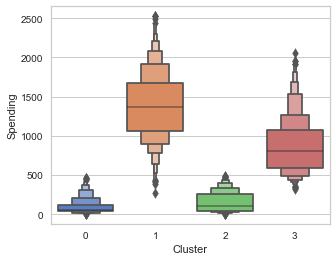

In [38]:
plt.figure(figsize=(5, 4))
sns.boxenplot(x=df2["Cluster"], y=df2["Spending"])
plt.show()

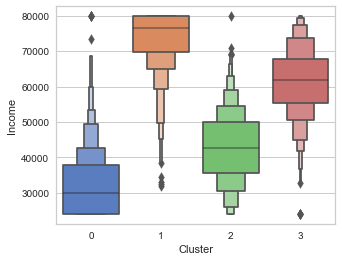

In [39]:
plt.figure(figsize=(5, 4))
sns.boxenplot(x=df2["Cluster"], y=df2["Income"])
plt.show()

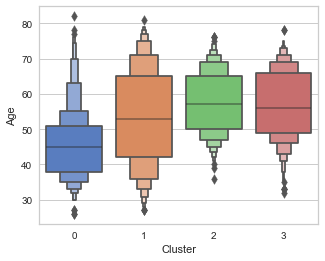

In [40]:
plt.figure(figsize=(5, 4))
sns.boxenplot(x=df2["Cluster"], y=df2["Age"])
plt.show()

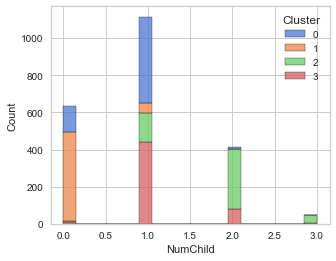

In [41]:
fig = plt.figure(figsize=(5,4))
sns.histplot(data=df2, x="NumChild", hue="Cluster", multiple="stack", palette = palette1)
plt.show()

From above plot, we can clearly identify unique charactisitc of each cluster. Lets explore the cluster in details in next section.


## Customer Profiling
Profiling means how do the segments differentiate each other. We can see that the groups are getting differentiated on the basis of income or income is segregating the segments.

The goal of Profiling is to be able to differentiate between the groups. It is an essential tool to validate if the groups formed via the clustering techniques are bring values to marketing strategies.

**Demographic**

<Figure size 576x396 with 0 Axes>

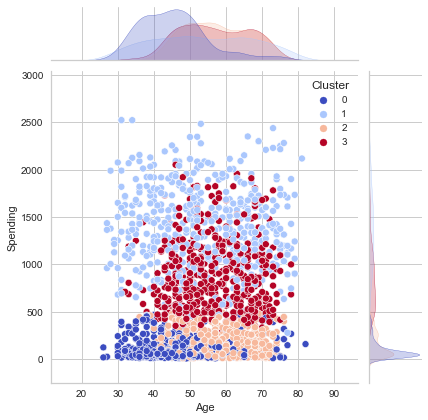

<Figure size 576x396 with 0 Axes>

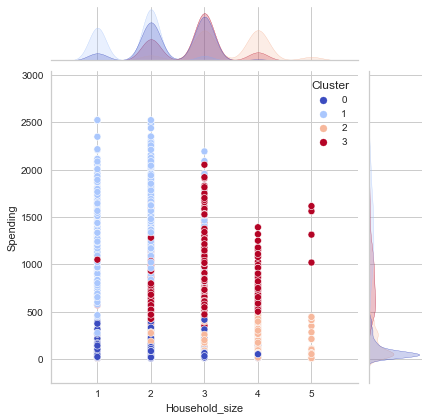

<Figure size 576x396 with 0 Axes>

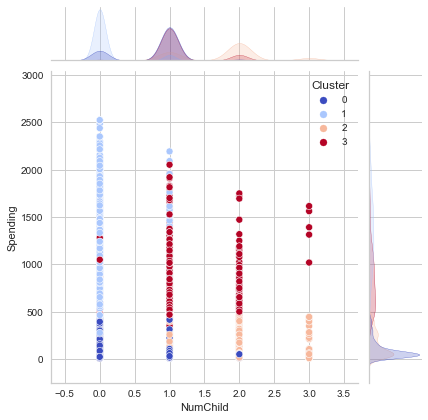

<Figure size 576x396 with 0 Axes>

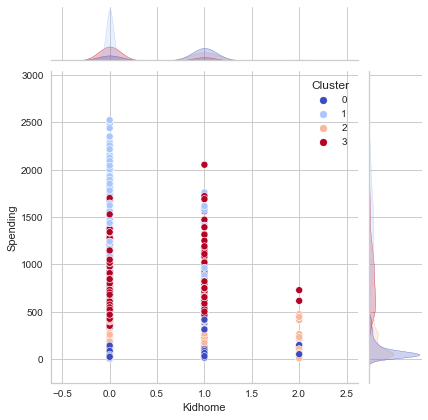

<Figure size 576x396 with 0 Axes>

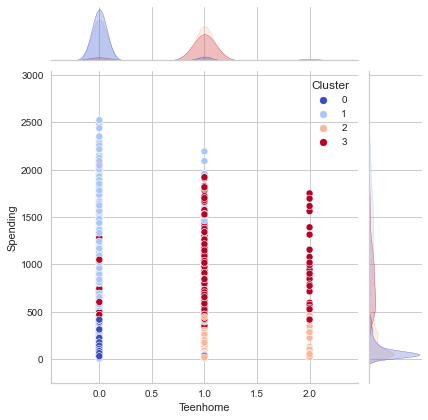

<Figure size 576x396 with 0 Axes>

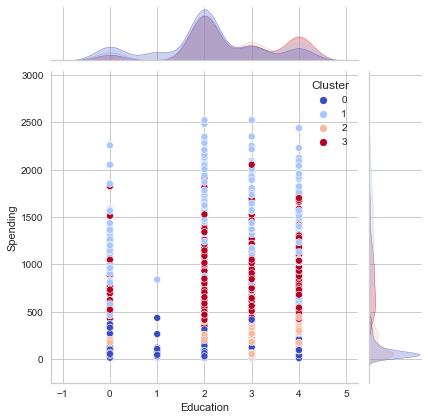

<Figure size 576x396 with 0 Axes>

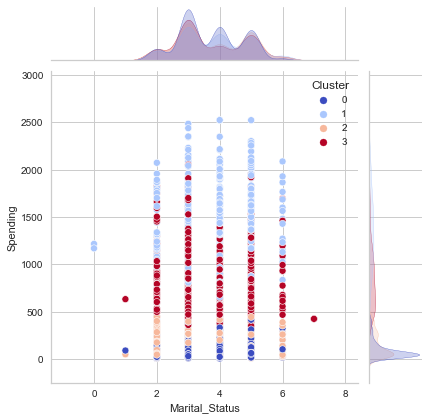

<Figure size 576x396 with 0 Axes>

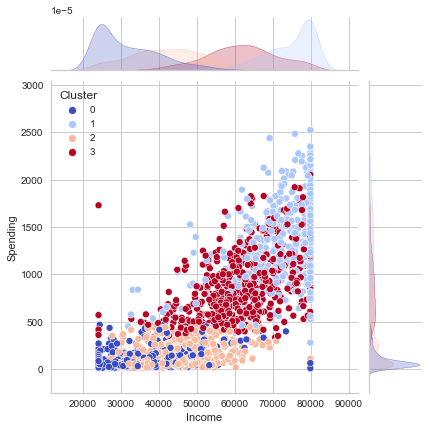

In [42]:
demographic_feature  = ['Age', 'Household_size', 'NumChild', 'Kidhome', 'Teenhome', 'Education', 'Marital_Status','Income']
for i in demographic_feature:
    plt.figure()
    sns.jointplot(x=df2[i], y=df2["Spending"], hue = df2["Cluster"],palette=palette2) 
    plt.show()
plt.show()

*Summary*
Education after encoding: {'2n Cycle': 0, 'Basic': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
Marital_Status after encoding: {'Absurd': 0, 'Alone': 1, 'Divorced': 2, 'Married': 3, 'Single': 4, 'Together': 5, 'Widow': 6, 'YOLO': 7}

Cluster 0
- Relatively Younger
- Majority are single or married without children
- Lower income group
- Most customer with 'Basic' education level come from this cluster

Cluster 1
- Span of age
- High income group

Cluster 2
- Middle age
- Definitly are Parent

Cluster 3
- Middle age
- Mostly are parent
- Marjority have teen at home

All clusters are span of Martial Status.

**Behavioural**

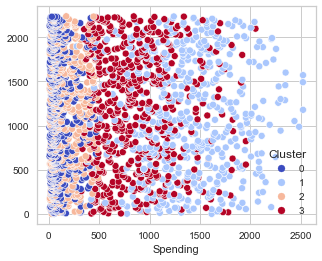

In [43]:
# Cluster spending
plt.figure(figsize=(5, 4))
sns.scatterplot(data = df2, x = df2['Spending'], y = df2.index, hue = df2["Cluster"], palette=palette2)
plt.show()

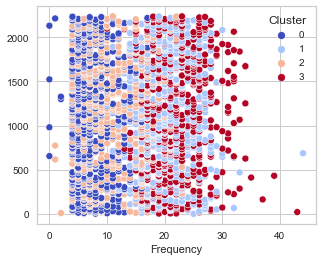

In [44]:
# Cluster purchase frequency
plt.figure(figsize=(5, 4))
sns.scatterplot(data = df2, x = df2['Frequency'], y = df2.index, hue = df2["Cluster"], palette=palette2)
plt.show()

<Figure size 576x396 with 0 Axes>

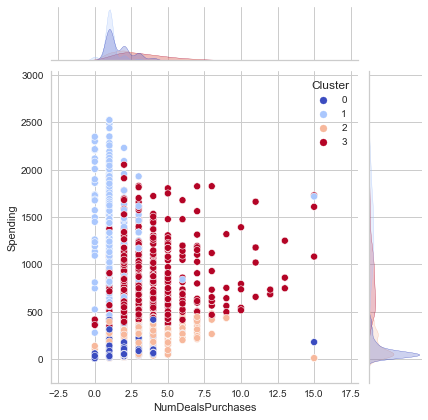

<Figure size 576x396 with 0 Axes>

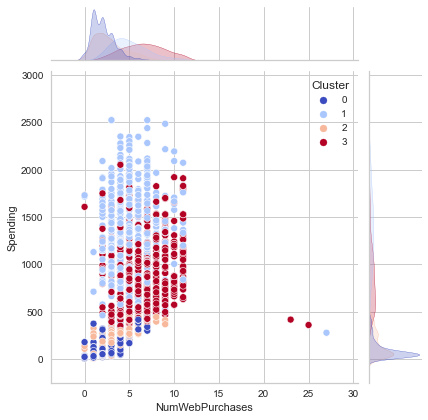

<Figure size 576x396 with 0 Axes>

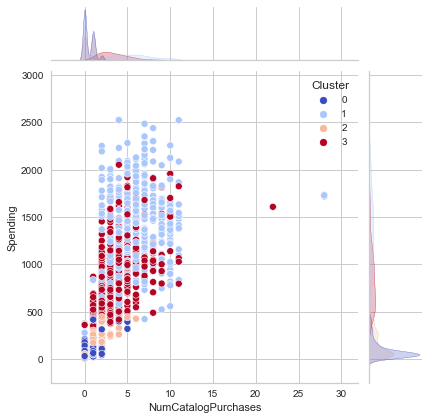

<Figure size 576x396 with 0 Axes>

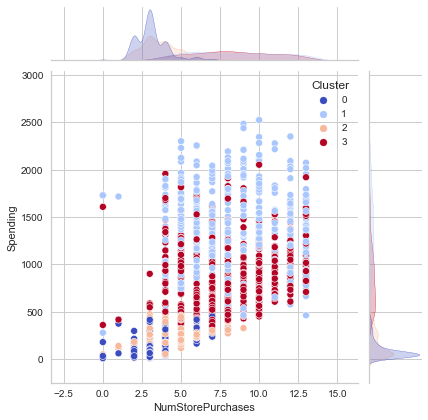

<Figure size 576x396 with 0 Axes>

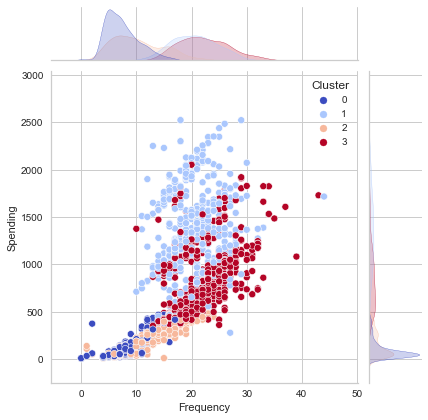

<Figure size 576x396 with 0 Axes>

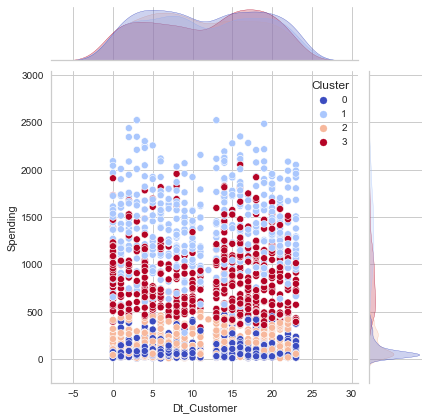

In [56]:
behavioral_feature = ['NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases', 'Frequency','Dt_Customer']
for i in behavioral_feature:
    plt.figure()
    sns.jointplot(x=df2[i], y=df2["Spending"], hue = df2["Cluster"], palette=palette2) 
    plt.show()
plt.show()

<Figure size 576x396 with 0 Axes>

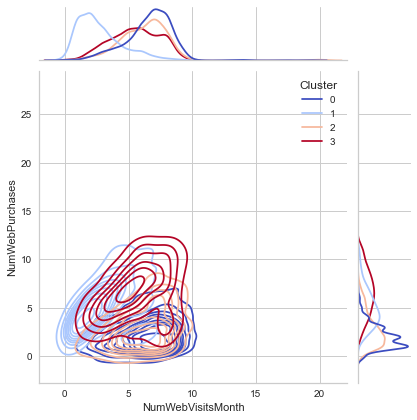

In [65]:
# Web conversion
plt.figure()
sns.jointplot(x=df2["NumWebVisitsMonth"], y=df2["NumWebPurchases"], hue = df2["Cluster"], palette=palette2, kind="kde") 
plt.show()

*Summary*

Cluster 0
- Rarely purchase via catalog
- Keen on deals
- Web conversion performance is better

Cluster 1
- Highest Spending group 
- Not keen on deals
- Frequently purchase in store
- Also purchase online
- Purchase frequency similar to Cluster 3 but higher spend
- Frequently purchase in store

Cluster 2
- Keen on deals
- Keen on web prchase Web conversion performance is better

Cluster 3
- Keen on deals
- Frequently purchase in store and online
- Purchase frequency similar to Cluster 1 but less spend

All clusters span of enrollment date.

***
<center> END OF LEARNING ツ
